In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
from scipy import sparse
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import GProfiler

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.3+115.g1aecabf anndata==0.6.22.post1 umap==0.3.9 numpy==1.16.4 scipy==1.3.0 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.0 python-igraph==0.7.1 louvain==0.6.1


In [3]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(slingshot)
library(monocle)
library(gam)
library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)

	Single-cell RNAseq data was collected on whole early mouse embryos. Each experiment consists of 4-10 replicates of developmental stages 6.5, 7.0, 7.5, 8.0, 8.5 for wild-type sequenced with 10X Genomics single-cell RNA sequencing system.

In [4]:
# Set up data loading

#Data files
sample_strings = ['E6.5_1', 'E7.0_1', 'E7.5_1']
file_base = '../data/mammalian-embryogenesis/GSE122187_WT_'
data_file_end = '_matrix.mtx'
barcode_file_end = '_barcodes.tsv'
gene_file_end = '_genes.tsv'
#cc_genes_file = '../Macosko_cell_cycle_genes.txt'

In [5]:
# First data set load & annotation
#Parse Filenames
sample = sample_strings.pop(0)
data_file = file_base+sample+data_file_end
barcode_file = file_base+sample+barcode_file_end
gene_file = file_base+sample+gene_file_end

#Load data
adata = sc.read(data_file, cache=True)
adata = adata.transpose()
#adata.X = adata.X.toarray()

barcodes = pd.read_csv(barcode_file, header=None, sep='\t')
genes = pd.read_csv(gene_file, header=None, sep='\t')

#Annotate data
barcodes.rename(columns={0:'barcode'}, inplace=True)
barcodes.set_index('barcode', inplace=True)
adata.obs = barcodes
adata.obs['sample'] = [sample]*adata.n_obs
adata.obs['stage'] = [sample.split("_")[0]]*adata.n_obs
adata.obs['exp_number'] = [sample.split("_")[1]]*adata.n_obs

genes.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
genes.set_index('gene_symbol', inplace=True)
adata.var = genes
print(adata)

... reading from cache file cache/..-data-mammalian-embryogenesis-GSE122187_WT_E6.5_1_matrix.h5ad
AnnData object with n_obs × n_vars = 1843 × 27998 
    obs: 'sample', 'stage', 'exp_number'
    var: 'gene_id'


In [6]:
#print(adata.obs['sample'])

In [7]:
# Loop to load rest of data sets
for i in range(len(sample_strings)):
    #Parse Filenames
    sample = sample_strings[i]
    data_file = file_base+sample+data_file_end 
    barcode_file = file_base+sample+barcode_file_end
    gene_file = file_base+sample+gene_file_end
    
    #Load data
    adata_tmp = sc.read(data_file, cache=True)
    adata_tmp = adata_tmp.transpose()
    #adata_tmp.X = adata_tmp.X.toarray()

    barcodes_tmp = pd.read_csv(barcode_file, header=None, sep='\t')
    genes_tmp = pd.read_csv(gene_file, header=None, sep='\t')
    
    #Annotate data
    barcodes_tmp.rename(columns={0:'barcode'}, inplace=True)
    barcodes_tmp.set_index('barcode', inplace=True)
    adata_tmp.obs = barcodes_tmp
    adata_tmp.obs['sample'] = [sample]*adata_tmp.n_obs
    adata_tmp.obs['stage'] = [sample.split("_")[0]]*adata_tmp.n_obs
    adata_tmp.obs['exp_number'] = [sample.split("_")[1]]*adata_tmp.n_obs
    
    genes_tmp.rename(columns={0:'gene_id', 1:'gene_symbol'}, inplace=True)
    genes_tmp.set_index('gene_symbol', inplace=True)
    adata_tmp.var = genes_tmp
    adata_tmp.var_names_make_unique()

    # Concatenate to main adata object
    adata = adata.concatenate(adata_tmp, batch_key='sample')
    #adata.obs.drop(columns=['sample'], inplace=True)
    adata.obs_names = [c.split("-")[0] for c in adata.obs_names]
    adata.obs_names_make_unique(join='_')

    
print(adata)


... reading from cache file cache/..-data-mammalian-embryogenesis-GSE122187_WT_E7.0_1_matrix.h5ad


Making variable names unique for controlled concatenation.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


... reading from cache file cache/..-data-mammalian-embryogenesis-GSE122187_WT_E7.5_1_matrix.h5ad


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 29917 × 27998 
    obs: 'exp_number', 'sample', 'stage'
    var: 'gene_id'


Once the data is read in and annotated, we test whether we have the expected number of cells for each region, mouse (donor), and sample.

In [8]:
# Annotate the data sets
print(adata.obs)
print(adata.obs['stage'].value_counts())
print('')
print(adata.obs['exp_number'].value_counts())
print('')
#print(adata.obs['sample'].value_counts())

                 exp_number sample stage
AAACCTGAGGTGTGGT          1      0  E6.5
AAACCTGGTAAGGATT          1      0  E6.5
AAACCTGGTACAGACG          1      0  E6.5
AAACCTGGTGTTCGAT          1      0  E6.5
AAACCTGTCAACACCA          1      0  E6.5
AAACGGGCATGTCCTC          1      0  E6.5
AAACGGGGTACATCCA          1      0  E6.5
AAACGGGTCCCTCTTT          1      0  E6.5
AAAGATGAGTCGTTTG          1      0  E6.5
AAAGATGCAGCTCGCA          1      0  E6.5
AAAGATGTCATGCTCC          1      0  E6.5
AAAGCAAAGTGAAGTT          1      0  E6.5
AAAGCAATCTCGTATT          1      0  E6.5
AAAGCAATCTTAGCCC          1      0  E6.5
AAAGTAGGTACACCGC          1      0  E6.5
AAAGTAGGTATGGTTC          1      0  E6.5
AAAGTAGGTGTGAAAT          1      0  E6.5
AAATGCCCAAATTGCC          1      0  E6.5
AAATGCCCAGATGAGC          1      0  E6.5
AAATGCCGTAATCACC          1      0  E6.5
AACACGTAGCTAACAA          1      0  E6.5
AACACGTCAAAGGAAG          1      0  E6.5
AACACGTCACAGGCCT          1      0  E6.5
AACACGTCATCGGGTC

In [9]:
# Checking the total size of the data set
adata.shape

(29917, 27998)

In [10]:
#print(adata.X)

In [11]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = np.ravel(adata.X.sum(1))
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)
print(np.ravel(adata.X.sum(1)))
mt_gene_mask = [gene.startswith('mt-') for gene in adata.var_names]
#print(adata.X[:, mt_gene_mask])
#print(np.ravel(adata.X[:, mt_gene_mask]))
print((adata.X.toarray()[:, mt_gene_mask]))
adata.obs['mt_frac'] = (adata.X.toarray()[:, mt_gene_mask]).sum(1)/adata.obs['n_counts']

[21203. 10915. 24615. ... 39751. 11579. 26029.]
[[106.  23.  94. ...  13.   0.  78.]
 [ 78.  31. 150. ...   3.   0.  74.]
 [ 83.  28.  64. ...  13.   0.  90.]
 ...
 [ 98.  37. 121. ...   1.   1.  83.]
 [ 45.  17.  48. ...   2.   0.  38.]
 [ 65.  29.  67. ...   5.   1.  80.]]


... storing 'exp_number' as categorical
... storing 'stage' as categorical


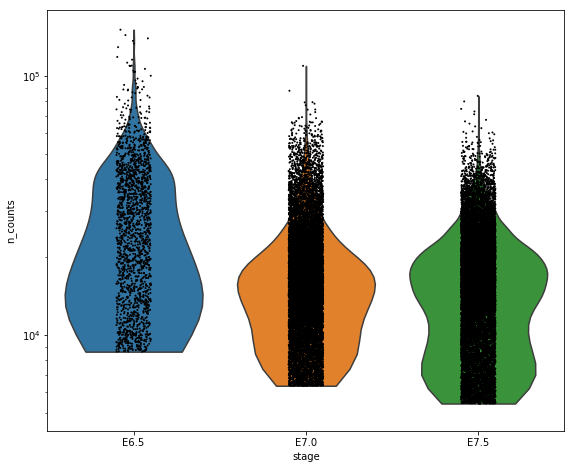

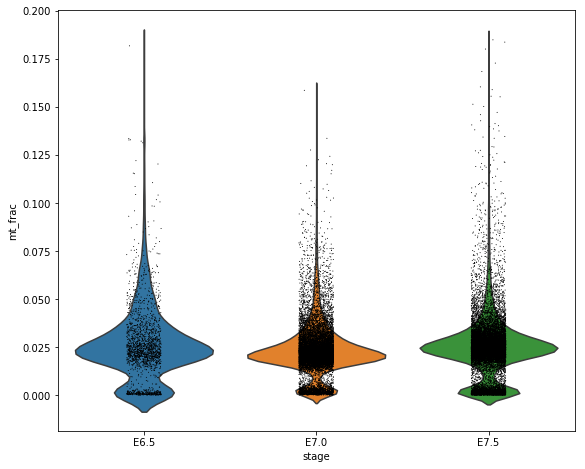

In [12]:
# Quality control - plot QC metrics
#Sample quality plots
t1 = sc.pl.violin(adata, 'n_counts', groupby='stage', size=2, log=True, cut=0)
t2 = sc.pl.violin(adata, 'mt_frac', groupby='stage')

Sample size for stage E6.5 is much smaller than the others and there appears to be two 'bulges'.

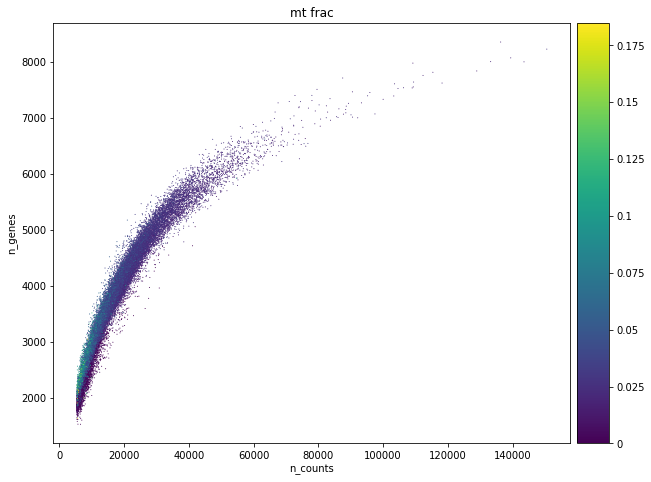

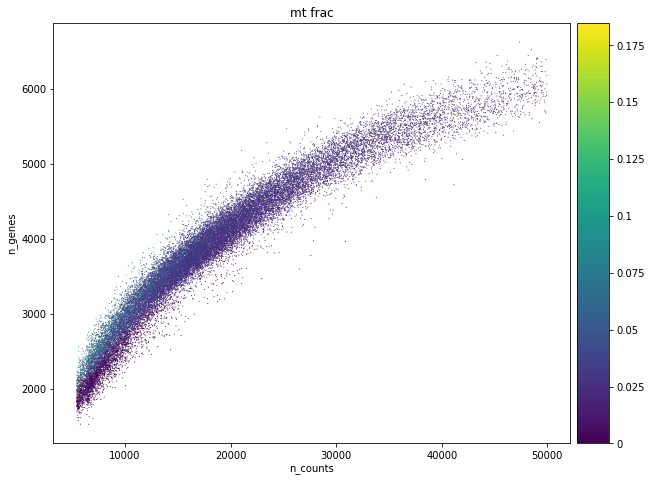

In [13]:
#Data quality summary plots
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac')
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<50000], 'n_counts', 'n_genes', color='mt_frac')

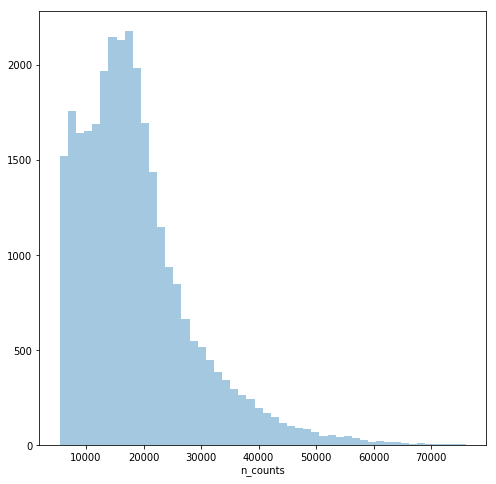

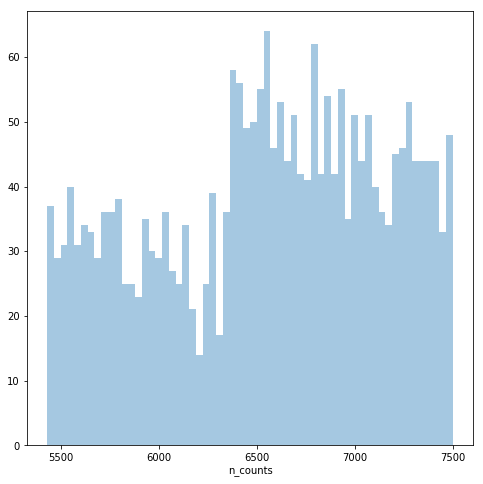

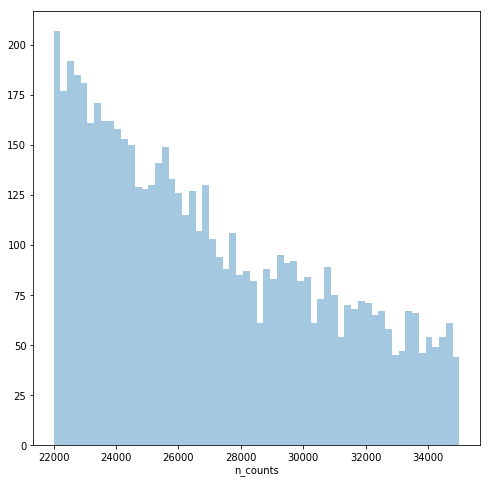

In [14]:
#Thresholding decision: counts
p3 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<76000], kde=False,)
plt.show()

p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<7500], kde=False, bins=60)
plt.show()

try_filter = adata.obs['n_counts'][(adata.obs['n_counts']>22000)  & (adata.obs['n_counts']<35000)]
p5 = sb.distplot(try_filter, kde=False, bins=60)
plt.show()

Histograms of the number of counts per cell show that there are two small peaks of groups of cells with fewer than 7000 counts. Given the overall distribution, unlikely to be informative.

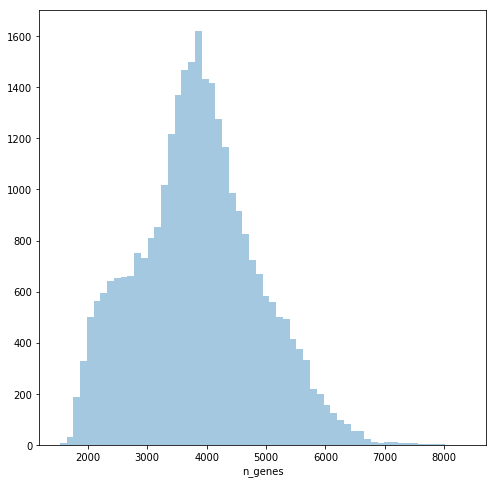

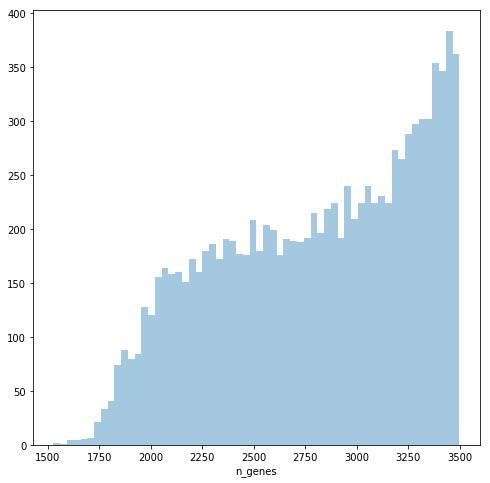

In [15]:
#Thresholding decision: genes
p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60)
plt.show()

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<3500], kde=False, bins=60)
plt.show()


In [16]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 10000)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts = 40000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] < 0.2]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes = 700)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))



Total number of cells: 29917
filtered out 5331 cells that haveless than 10000 counts
Number of cells after min count filter: 24586
filtered out 1326 cells that havemore than 40000 counts
Number of cells after max count filter: 23260
Number of cells after MT filter: 23260


Trying to set attribute `.obs` of view, making a copy.


Number of cells after gene filter: 23260


In [17]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 27998
filtered out 10845 genes that are detectedin less than 20 cells
Number of genes after cell filter: 17153


The filtering is performed based on the thresholds we identified from the QC plots. Genes are also filtered if they are not detected in at least 20 cells. This reduces the dimensions of the matrix by removing 0 count genes and genes which are not sufficiently informative of the dataset. 

## 2.2 Normalisation

Up to this point the data is only available as a count matrix. Counts are representative of molecules that were captured in the scRNA-seq experiment. As not all mRNA molecules in a cell are captured, there is a variability in the total number of counts detected between cells that results from both the number of molecules that were in the cells, and the sampling. As we cannot assume that all cells contain an equal number of molecules (cell sizes can differ substantially), we have to estimate the number of molecules that were initially in the cells. In fact, we don't estimate the exact number of molecules, but instead estimate cell-specific factors that should be proportional to the true number of molecules. These are called size factors. Normalized expression values are calculated by dividing the measured counts by the size factor for the cell.

Based on comparisons of normalization methods for differential testing (personal communication from Beathe Vieth), and batch correction [Buettner et al., 2019], the normalization method implemented in the scran package performs best. This method requires a coarse clustering input to improve size factor esimation performance. Thus, we use a simple preprocessing approach and cluster the data at a low resolution to get an input for the size factor estimation. The basic preprocessing includes assuming all size factors are equal (library size normalization to counts per million - CPM) and log-transforming the count data.

In [18]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 15
    finished (0:00:07)
computing neighbors
    using 'X_pca' with n_pcs = 15


/home/hunge/anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /home/hunge/anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/rp_tree.py (457)

File "../../anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(type(CPUDi

    finished (0:00:06)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:02)


In [19]:
print(adata.obs)

                 exp_number sample stage  n_counts  log_counts  n_genes  \
AAACCTGAGGTGTGGT          1      0  E6.5   21203.0    9.961898     4314   
AAACCTGGTAAGGATT          1      0  E6.5   10915.0    9.297894     3277   
AAACCTGGTACAGACG          1      0  E6.5   24615.0   10.111112     4502   
AAACCTGGTGTTCGAT          1      0  E6.5   19251.0    9.865318     4413   
AAACCTGTCAACACCA          1      0  E6.5   10544.0    9.263312     2767   
AAACGGGCATGTCCTC          1      0  E6.5   25772.0   10.157043     4840   
AAACGGGGTACATCCA          1      0  E6.5   21079.0    9.956033     4130   
AAACGGGTCCCTCTTT          1      0  E6.5   16334.0    9.701004     4159   
AAAGATGCAGCTCGCA          1      0  E6.5   24153.0   10.092164     4558   
AAAGATGTCATGCTCC          1      0  E6.5   12771.0    9.454932     3652   
AAAGCAAAGTGAAGTT          1      0  E6.5   37439.0   10.530468     5170   
AAAGTAGGTATGGTTC          1      0  E6.5   37929.0   10.543471     5416   
AAAGTAGGTGTGAAAT         

In [20]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
#print(adata.X)
print(input_groups)
data_mat = adata.X.T

AAACCTGAGGTGTGGT    12
AAACCTGGTAAGGATT     7
AAACCTGGTACAGACG    12
AAACCTGGTGTTCGAT     7
AAACCTGTCAACACCA    12
AAACGGGCATGTCCTC    12
AAACGGGGTACATCCA     7
AAACGGGTCCCTCTTT    12
AAAGATGCAGCTCGCA     7
AAAGATGTCATGCTCC     7
AAAGCAAAGTGAAGTT     6
AAAGTAGGTATGGTTC     3
AAAGTAGGTGTGAAAT     6
AAATGCCCAGATGAGC    11
AAATGCCGTAATCACC     6
AACACGTCAAAGGAAG     7
AACACGTCATCGGGTC     1
AACACGTGTTGGGACA     6
AACCATGAGCCTATGT    12
AACCATGCACAACGTT    12
AACCGCGAGGTCATCT     7
AACGTTGAGGGCTCTC     3
AACGTTGCACTGTCGG     1
AACTCAGTCCTTCAAT     6
AACTCCCAGGTCATCT     6
AACTCCCCAATACGCT     7
AACTCCCGTGAGTATA    12
AACTGGTAGACGCAAC    12
AACTGGTAGTGGAGAA     3
AACTGGTTCGGTTAAC    11
                    ..
TTTGGTTGTCTTGATG     9
TTTGGTTGTTGTGGAG     0
TTTGGTTTCAACACGT     4
TTTGGTTTCATATCGG     2
TTTGGTTTCATGCTCC     8
TTTGGTTTCCTACAGA     2
TTTGGTTTCTAACTTC     0
TTTGTCAAGACTTGAA     9
TTTGTCAAGATTACCC     6
TTTGTCAAGCATGGCA     0
TTTGTCAAGCGGATCA    10
TTTGTCAAGCTACCTA     0
TTTGTCAAGGA

In [21]:
#print(data_mat)

In [22]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [23]:
#Delete adata_pp
del adata_pp

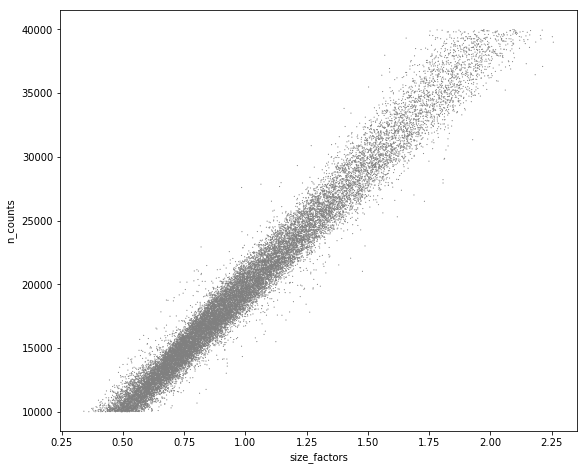

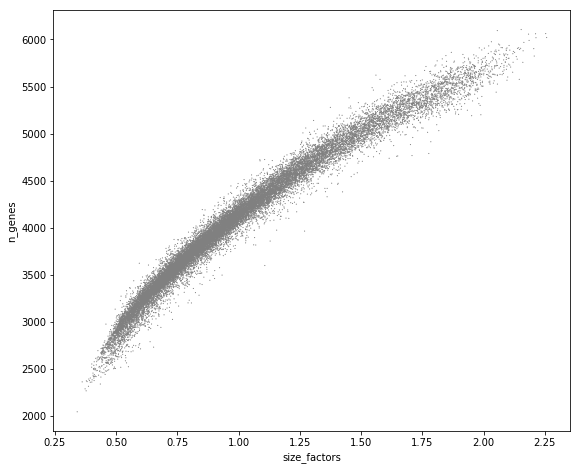

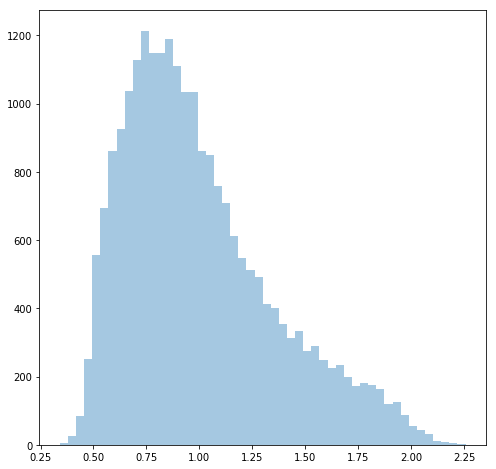

In [24]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sb.distplot(size_factors, bins=50, kde=False)
plt.show()

We plot the size factors to show they are non-negative and related to the number of counts and genes per cell as expected.

Before normalizing the data, we ensure that a copy of the raw count data is kept in a separate AnnData object. This allows us to use methods downstream that require this data as input.

In [25]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [26]:
#Normalize adata - converted to dense matrix so convert back
adata.X /= adata.obs['size_factors'].values[:,None]
print(adata.X)
sc.pp.log1p(adata)
adata.X = sparse.csr_matrix(adata.X)

[[0.         0.         0.         ... 0.92342029 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.83452823 1.66905645 0.        ]
 ...
 [0.         0.         0.         ... 0.49492773 0.49492773 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 1.44573474 0.         0.        ]]


In [27]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

The count data has been normalized and log-transformed with an offset of 1. The latter is performed to normalize the data distributions. The offset of 1 ensures that zero counts map to zeros. We keep this data in the '.raw' part of the AnnData object as it will be used to visualize gene expression and perform statistical tests such as computing marker genes for clusters.

## 2.3 Batch Correction
Batch correction is performed to adjust for batch effects from the 6 samples that were loaded. As the batch effect from samples and are overlapping, correcting for this batch effect will also partially regress out differences between samples. We allow for this to optimally cluster the data. This approach can also be helpful to find differentiation trajectories, but we revert back to non-batch-corrected data for differential testing and computing marker genes.

Note that ComBat batch correction requires a dense matrix format as input (which is already the case in this example).

In [28]:
# ComBat batch correction
#sc.pp.combat(adata, key='stage')

## 2.4 Highly Variable Genes

We extract highly variable genes (HVGs) to further reduce the dimensionality of the dataset and include only the most informative genes. Genes that vary substantially across the dataset are informative of the underlying biological variation in the data. As we only want to capture biological variation in these genes, we select highly variable genes after normalization and batch correction. HVGs are used for clustering, trajectory inference, and dimensionality reduction/visualization, while the full data set is used for computing marker genes, differential testing, cell cycle scoring, and visualizing expression values on the data.

Here we use a standard technique for the extraction of highly variable genes from the 10X genomics preprocessing software CellRanger. Typically between 1000 and 5000 genes are selected. Here, we extract the top 4000 most variable genes for further processing. If particular genes of importance are known, one could assess how many highly variable genes are necessary to include all, or the majority, of these.

In [29]:
print(adata.X)

  (0, 3)	1.046209810414354
  (0, 4)	1.046209810414354
  (0, 6)	0.654105001877114
  (0, 18)	1.3271441947536389
  (0, 25)	1.5462171694698466
  (0, 28)	0.654105001877114
  (0, 29)	1.046209810414354
  (0, 38)	0.654105001877114
  (0, 47)	3.728832896997712
  (0, 49)	0.654105001877114
  (0, 50)	1.046209810414354
  (0, 51)	2.231173148253094
  (0, 53)	0.654105001877114
  (0, 63)	1.7258157739599809
  (0, 65)	0.654105001877114
  (0, 76)	0.654105001877114
  (0, 77)	1.5462171694698466
  (0, 84)	1.046209810414354
  (0, 87)	0.654105001877114
  (0, 91)	0.654105001877114
  (0, 93)	0.654105001877114
  (0, 94)	1.8780169383551684
  (0, 95)	1.046209810414354
  (0, 101)	0.654105001877114
  (0, 105)	0.654105001877114
  :	:
  (23259, 17075)	0.5439899791278977
  (23259, 17080)	2.1076248489574088
  (23259, 17084)	0.5439899791278977
  (23259, 17085)	0.5439899791278977
  (23259, 17090)	0.5439899791278977
  (23259, 17099)	0.5439899791278977
  (23259, 17101)	0.5439899791278977
  (23259, 17118)	1.67470196301368
  (2

In [30]:

sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))

extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 4000


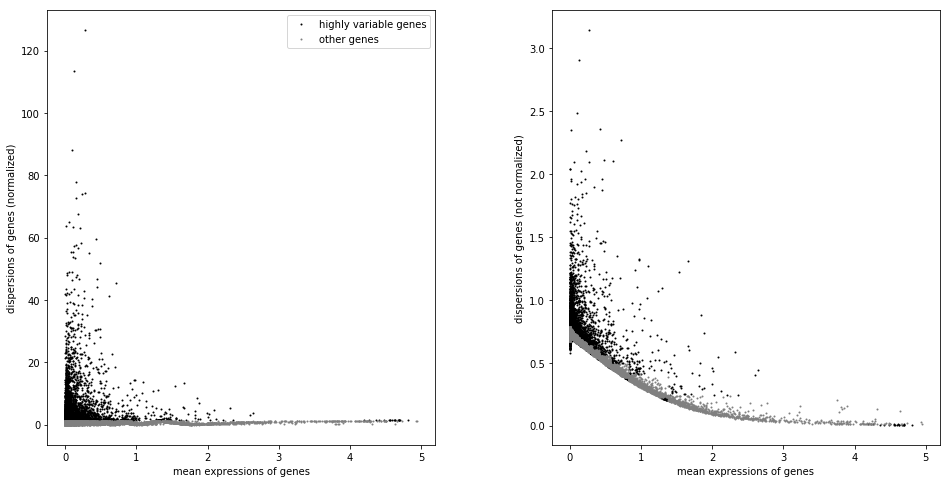

In [31]:
sc.pl.highly_variable_genes(adata)

## 2.5 Visualisation

Visualizing scRNA-seq data is the process of projecting a high-dimensional matrix of cells and genes into a few coordinates such that every cell is meaningfully represented in a two-dimensional graph. However, the visualization of scRNA-seq data is an active area of research and each method defines 'meaningful' in its own way. Thus, it is a good idea to look at several visualizations and decide which visualization best represents the aspect of the data that is being investigated.

Overall t-SNE visualizations have been very popular in the community, however the recent UMAP algorithm has been shown to better represent the topology of the data.

Note that we do not scale the genes to have zero mean and unit variance. A lack of rescaling is equivalent to giving genes with a higher mean expression a higher weight in dimensionality reduction (despite correcting for mean offsets in PCA, due to the mean-variance relationship). We argue that this weighting based on mean expression being a biologically relevant signal. However, rescaling HVG expression is also common, and the number of publications that use this approach suggests that scaling is at least not detrimental to downstream scRNA-seq analysis.

In [32]:
# Calculate the visualizations

sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.tsne(adata, n_jobs=12) #Note n_jobs works for MulticoreTSNE, but not regular implementation)
sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:17)
computing neighbors
    using 'X_pca' with n_pcs = 50


/home/hunge/anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /home/hunge/anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/rp_tree.py (457)

File "../../anaconda3/envs/sc-tutorial/lib/python3.7/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(type(CPUDi

    finished (0:00:05)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:01:24)
computing UMAP
    finished (0:00:25)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9984296  0.99787134 0.99581766 0.99342823 0.9916544
     0.99039525 0.9883832  0.9868595  0.9858868  0.98509425 0.98390156
     0.98357636 0.9833142  0.9826048 ]
    finished (0:00:01)
drawing single-cell graph using layout 'fa'
    finished (0:02:34)


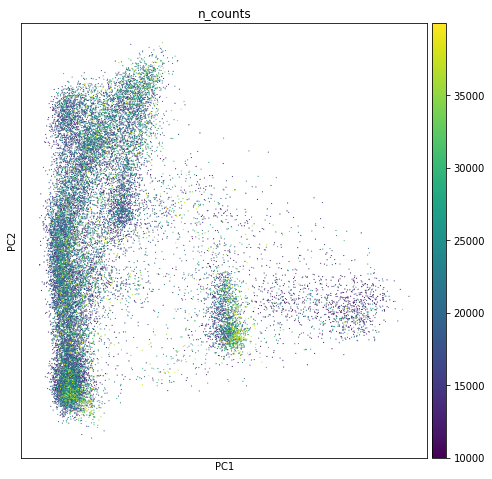

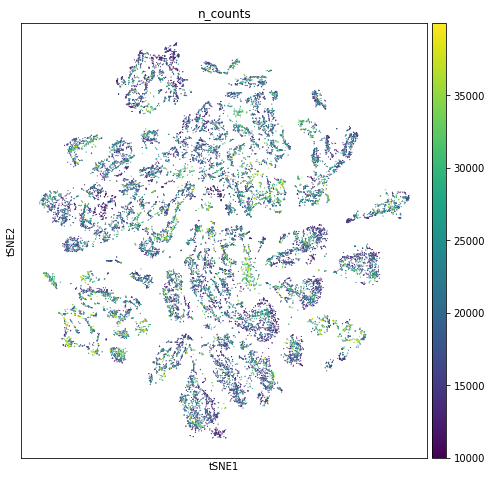

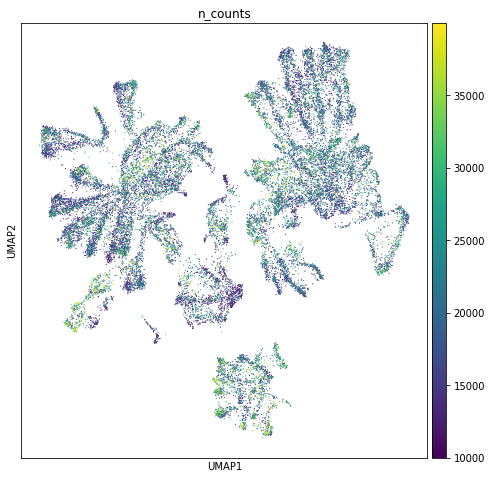

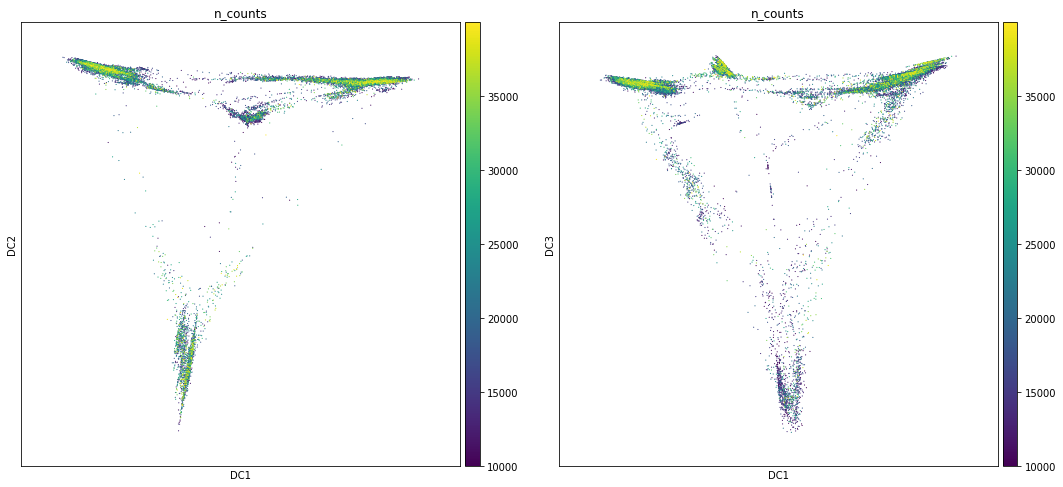

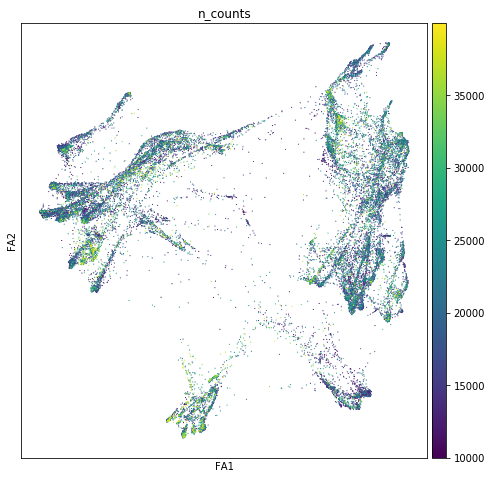

In [33]:
sc.pl.pca_scatter(adata, color='n_counts')
sc.pl.tsne(adata, color='n_counts')
sc.pl.umap(adata, color='n_counts')
sc.pl.diffmap(adata, color='n_counts', components=['1,2','1,3'])
sc.pl.draw_graph(adata, color='n_counts')

PCA:

- Unsurprisingly, the first principle component captures variation in count depth between cells, and is thus only marginally informative
- The plot does not show the expected clustering of the data in two dimensions

t-SNE:

- Shows many distinct clusters with clear subcluster structure
- Connections between clusters are difficult to interpret visually

UMAP:

- Data points are spread out on the plot showing several clusters
- Connections between clusters can be readily identified

Diffusion Maps:

- Shows connections between regions of higher density
- Very clear trajectories are suggested, but clusters are less clear
- Each diffusion component extracts heterogeneity in a different part of the data

Graph:

- Shows two main clusters and several outer clusters


The strengths and weaknesses of the visualizations can readily be identified in the above plots. While t-SNE exaggerates differences, diffusion maps exaggerate transitions. Overall UMAP and force-directed graph drawings show the best compromise of the two aspects, however UMAP is much faster to compute (8s vs 114s here). UMAP has furthermore been shown to more accurately display the structure in the data.

## 3 Downstream Analysis

## 3.1 Clustering

Clustering is a central component of the scRNA-seq analysis pipeline. To understand the data, we must identify cell types and states present. The first step of doing so is clustering. Performing Modularity optimization by Louvain community detection on the k-nearest-neighbour graph of cells has become an established practice in scRNA-seq analysis. Thus, this is the method of choice in this tutorial as well.

Here, we perform clustering at two resolutions. Investigating several resolutions allows us to select a clustering that appears to capture the main clusters in the visualization and can provide a good baseline for further subclustering of the data to identify more specific substructure.

Clustering is performed on the highly variable gene data, dimensionality reduced by PCA, and embedded into a KNN graph. (see sc.pp.pca() and sc.pp.neighbors() functions used in the visualization section.

[Timing: 8.08s]

In [34]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata, key_added='louvain_r1')
sc.tl.louvain(adata, resolution=0.5, key_added='louvain_r0.5', random_state=10)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:02)


In [35]:
adata.obs['louvain_r0.5'].value_counts()

0     2995
1     2111
2     1910
3     1892
4     1660
5     1510
6     1429
7     1349
8     1323
9     1207
10    1050
11    1008
12     607
13     597
14     568
15     538
16     530
17     485
18     412
19      79
Name: louvain_r0.5, dtype: int64

In [36]:
adata.obs['louvain_r1'].value_counts()

0     1753
1     1427
2     1359
3     1294
4     1287
5     1277
6     1207
7     1202
8     1193
9     1189
10    1075
11     981
12     761
13     733
14     683
15     662
16     653
17     626
18     608
19     562
20     552
21     535
22     528
23     486
24     247
25     162
26     139
27      79
Name: louvain_r1, dtype: int64

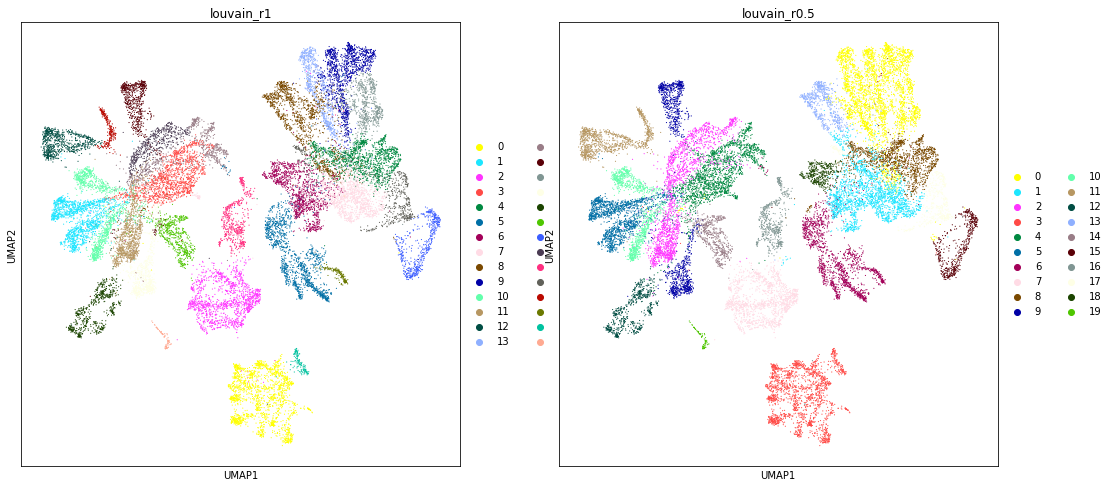

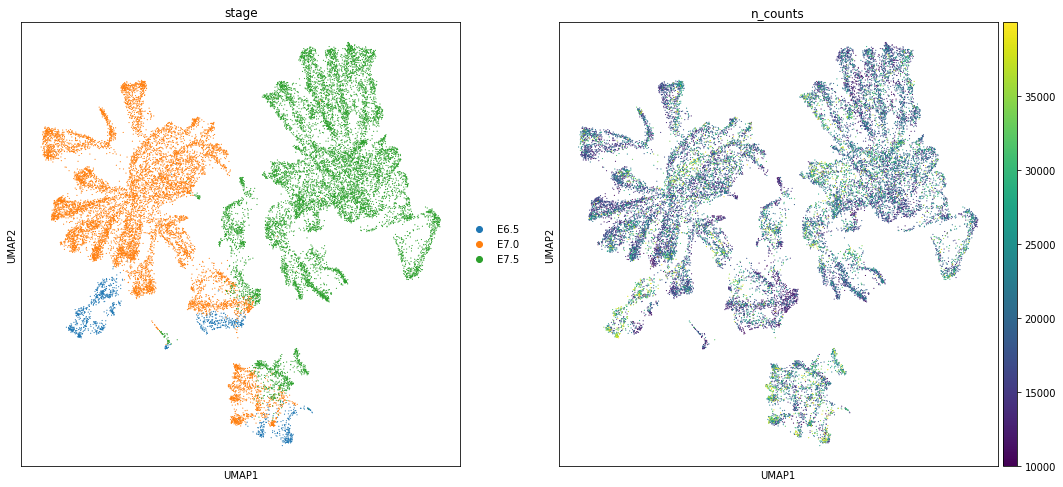

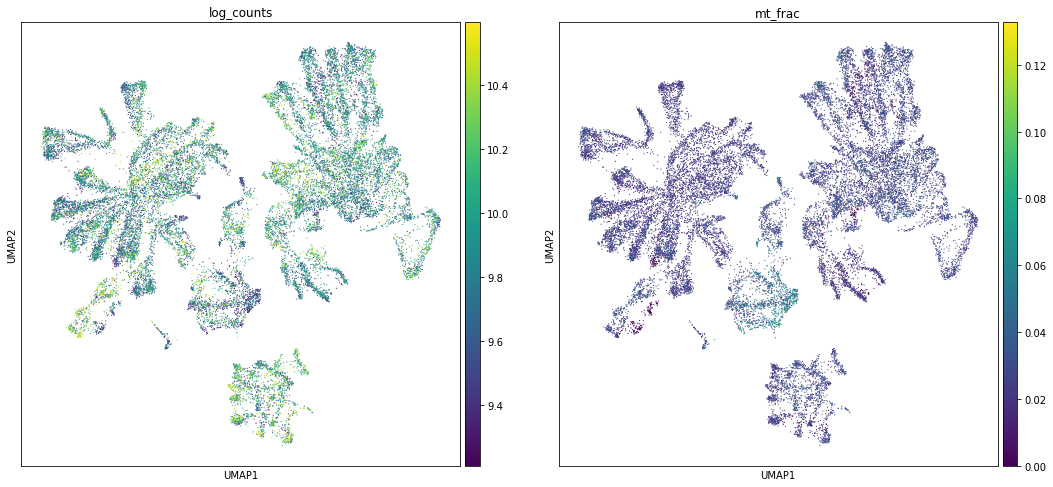

In [37]:
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata, color=['louvain_r1', 'louvain_r0.5'], palette=sc.pl.palettes.default_64)
sc.pl.umap(adata, color=['stage', 'n_counts'])
sc.pl.umap(adata, color=['log_counts', 'mt_frac'])

At a resolution of 0.5 the broad clusters in the visualization are captured well in the data. 

At a resolution of 0.5, cluster 7 is composed of cells from the three stages and appears to have higher mitochrondrial read fractions. Stage E7.5 appears to have lower counts than the other stages in this cluster and higher mitochondrial read fractions - this indicates cell stress.

In the case of cluster 6 this may be biologically relevant, while cluster 0 is also characterized by higher mitochondrial read fractions. This indicates cell stress.

The variation captured by the clustering is shown to be related to the stages. This suggests we are not successfully detecting cell types across regions as was intended.



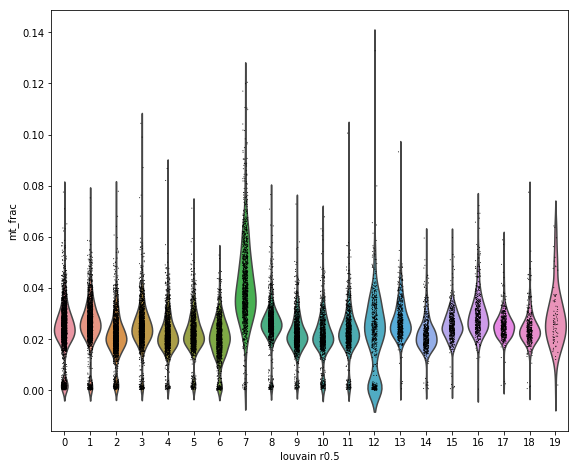

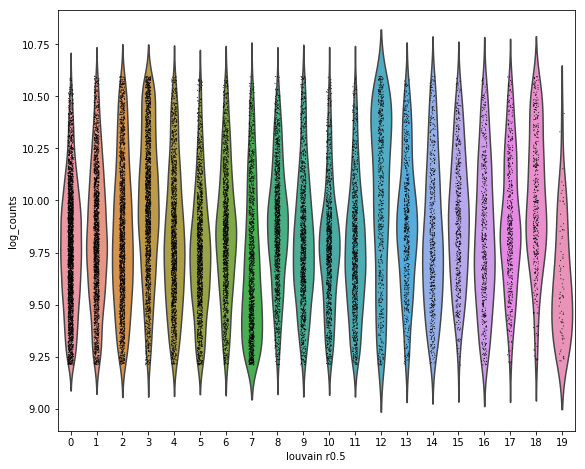

In [38]:
sc.pl.violin(adata, 'mt_frac', groupby='louvain_r0.5')
sc.pl.violin(adata, 'log_counts', groupby='louvain_r0.5')

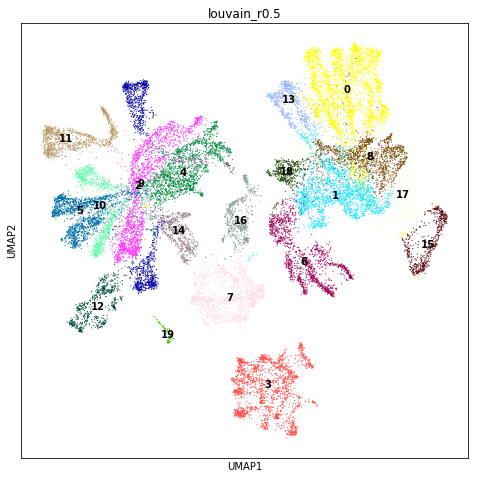

In [39]:
sc.pl.umap(adata, color='louvain_r0.5', palette=sc.pl.palettes.default_64, legend_loc='on data')

## 3.5 Trajectory inference and pseudotime analysis

As our data set contains differentiation processes, we can investigate the differentiation trajectories in the data. This analysis is centred around the concept of 'pseudotime'. In pseudotime analysis a latent variable is inferred based on which the cells are ordered. This latent variable is supposed to measure the differentiation state along a trajectory.

Pseudotime analysis is complicated when there are multiple trajectories in the data. In this case, the trajectory structure in the data must first be found before pseudotime can be inferred along each trajectory. The analysis is then called 'trajectory inference'.

Once the pseudotime variable is inferred, we can test for genes that vary continuously along pseudotime. These genes are seen as being associated with the trajectory, and may play a regulatory role in the potential differentiation trajectory that the analysis found.

##### Here, we measure the trajectory from E6.5_1 to E7.5_1. We also investigate which genes vary along pseudotime.

Based on a recent comparison of pseudotime methods [Saelens et al., 2018], we have selected the top performing 'Slingshot', 'Monocle2', and 'Diffusion Pseudotime (DPT)'. Three methods were chosen as trajectory inference is a complex problem which is not yet solved. Different methods perform well on different types of trajectories. For example, 'Slingshot' was the top performer for simple bifurcating and multifurcating trajectories; 'Monocle2' performed best for complex tree structures, and 'DPT' performed well in bifurcating trajectories and was used in the Haber et al paper from which we took this dataset. As the complexity of trajectories are generally not known, it is adviseable to compare trajectory inference outputs.

[Timing: 63min 42s; Timings for each method given in subsections]

In [40]:
adata.obs['louvain_r0.5'].value_counts()

0     2995
1     2111
2     1910
3     1892
4     1660
5     1510
6     1429
7     1349
8     1323
9     1207
10    1050
11    1008
12     607
13     597
14     568
15     538
16     530
17     485
18     412
19      79
Name: louvain_r0.5, dtype: int64

In [41]:
#print(adata.var['highly_variable'])

In [42]:
#Subsetting to relevant clusters
#clusters_to_include = [g for g in adata.obs['louvain_r0.5'].cat.categories]
#adata_ent = adata[np.isin(adata.obs['louvain_r0.5']).copy()]
#Subset to highly variable genes
#adata_red = adata[np.isin(adata.obs['louvain_r0.5'], clusters_to_include), :].copy()
#print(adata_red)
#print(adata.obs['louvain_r0.5'])
#sc.pp.highly_variable_genes(adata_red, flavor='cell_ranger', n_top_genes=4000, subset=True)

In [43]:
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))


 Number of highly variable genes: 4000


In [ ]:
#Recalculating PCA for subset
sc.pp.pca(adata, svd_solver='arpack')
sc.pl.pca(adata)
sc.pl.pca_variance_ratio(adata)

computing PCA with n_comps = 50
computing PCA on highly variable genes


In [40]:
%%R -i adata_ent

#Plot 1
colour_map = brewer.pal(20,'Set1')
par(xpd=TRUE)
par(mar=c(4.5,5.5,2,7))
plot(reducedDims(adata_ent)$PCA[,1], reducedDims(adata_ent)$PCA[,2], col=colour_map[colData(adata_ent)$louvain_final], bty='L', xlab='PC1', ylab='PC2')
legend(x=12, y=12, legend=unique(colData(adata_ent)$louvain_final), fill=colour_map[as.integer(unique(colData(adata_ent)$louvain_final))])

print("1:")
adata_ent_start <- slingshot(adata_ent, clusterLabels = 'louvain_final', reducedDim = 'PCA', start.clus='Stem')
print(SlingshotDataSet(adata_ent_start))

print("")
print("2:")
adata_ent_startend <- slingshot(adata_ent, clusterLabels = 'louvain_final', reducedDim = 'PCA', start.clus='Stem', end.clus=c('Enterocyte mat. (Proximal)', 'Enterocyte mat. (Distal)'))
print(SlingshotDataSet(adata_ent_startend))

print("")
print("3:")
adata_ent_simple_startend <- slingshot(adata_ent, clusterLabels = 'louvain_r0.5', reducedDim = 'PCA', start.clus='Stem', end.clus='Enterocyte')
print(SlingshotDataSet(adata_ent_simple_startend))


Error in plot.window(...) : need finite 'xlim' values
Calls: <Anonymous> ... plot -> plot -> plot.default -> localWindow -> plot.window


## 3.5.3 Monocle2

The monocle toolbox is one of the most popular trajectory inference toolboxes in the field. It has been shown to perform particularly well on complex trajectories. Although we only have a simple bi- or multifurcating trajectory here we use Monocle2 to confirm the obtained trajectory.

Monocle2 is not as much a standalone trajectory inference method, than a trajectory inference toolbox. This toolbox includes preprocessing steps and a dimensionality reduction function. It is designed in such a way that integrating preprocessed data into the data structure is non-trivial. This is likely by intent to not interfere with the optimized pipeline. Thus, we use Monocle2 on our data set from the raw data. Our cluster labels are later overlayed onto the Monocle2 output to compare the trajectory with expectations.

Implementation note:

this section closely follows the monocle 2 tutorial

In [41]:
#Preprocessing for monocle
data_mat_mon = adata.layers['counts'].T
var_mon=adata.var.copy()
obs_mon=adata.obs.copy()

In [42]:
sc.pp.neighbors(adata_ent)
sc.tl.diffmap(adata_ent)

computing neighbors
    using 'X_pca' with n_pcs = 50


ValueError: Found array with 0 sample(s) (shape=(0, 50)) while a minimum of 1 is required by check_pairwise_arrays.

running PAGA
    finished (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


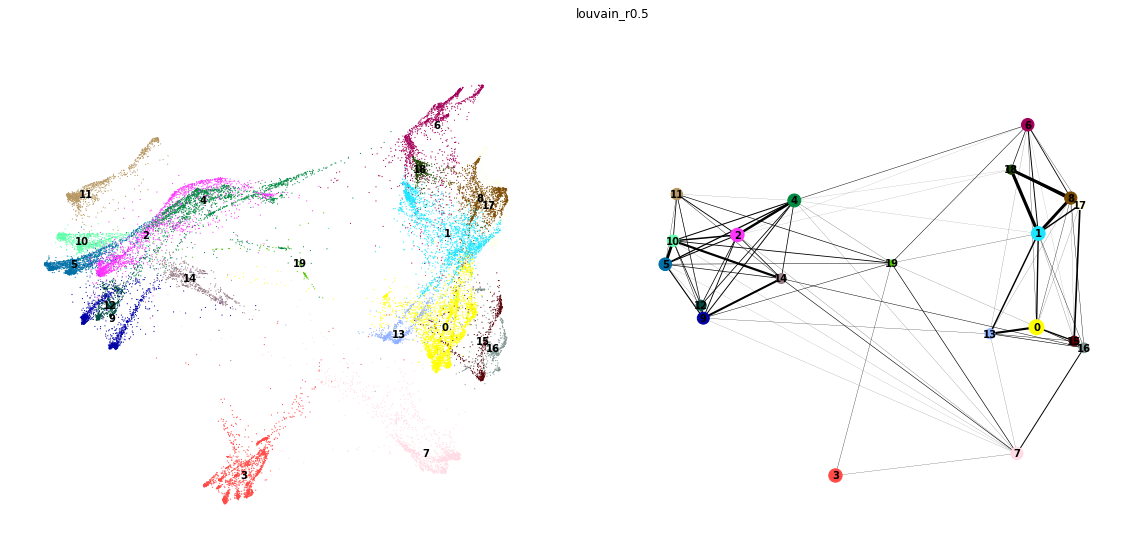

--> added 'pos', the PAGA positions (adata.uns['paga'])


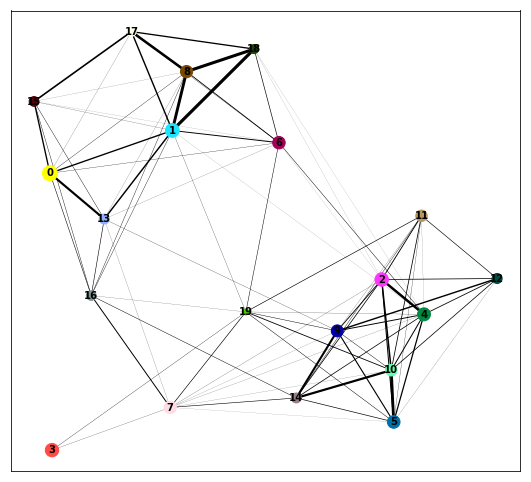

In [44]:
sc.tl.paga(adata, groups='louvain_r0.5')
sc.pl.paga_compare(adata)
sc.pl.paga(adata)

running PAGA
    finished (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])


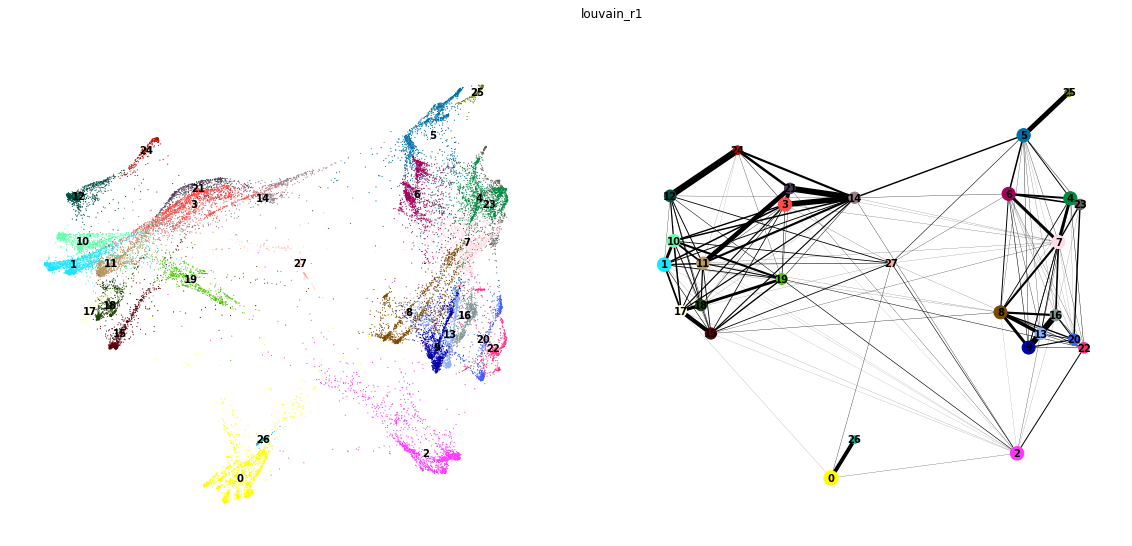

--> added 'pos', the PAGA positions (adata.uns['paga'])


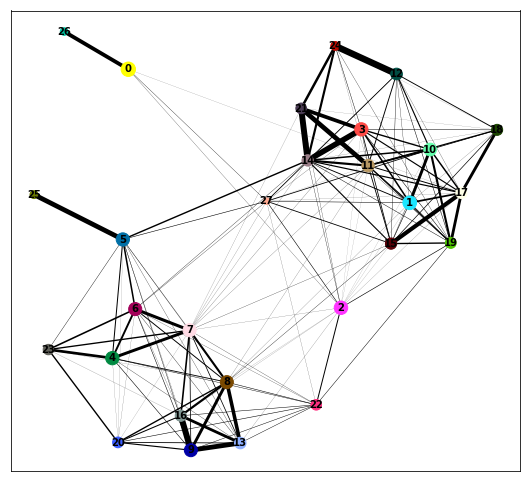

In [45]:
sc.tl.paga(adata, groups='louvain_r1')
sc.pl.paga_compare(adata)
sc.pl.paga(adata)

--> added 'pos', the PAGA positions (adata.uns['paga'])


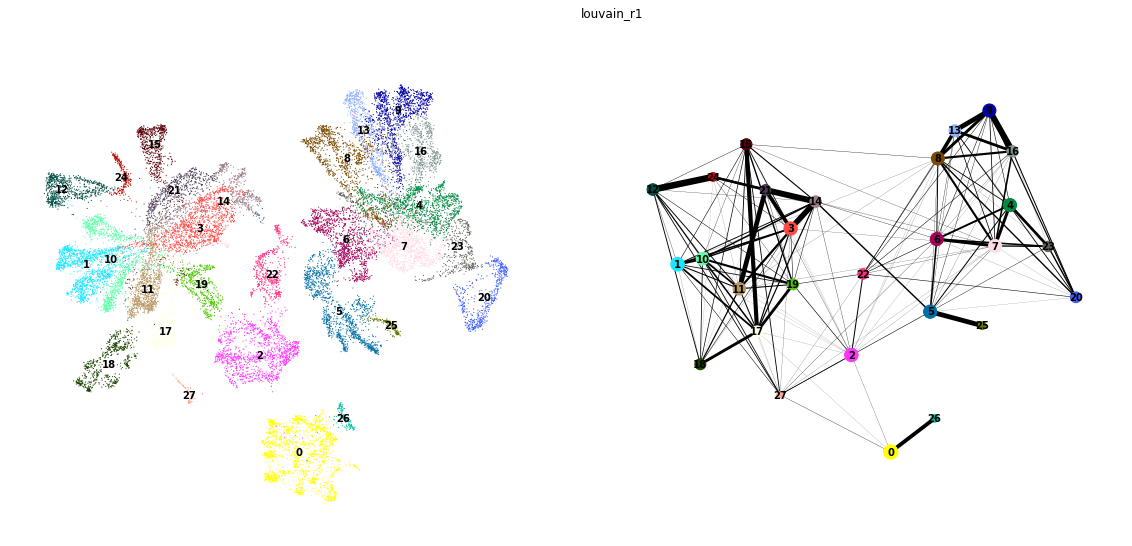

In [46]:
sc.pl.paga_compare(adata, basis='umap')

--> added 'pos', the PAGA positions (adata.uns['paga'])


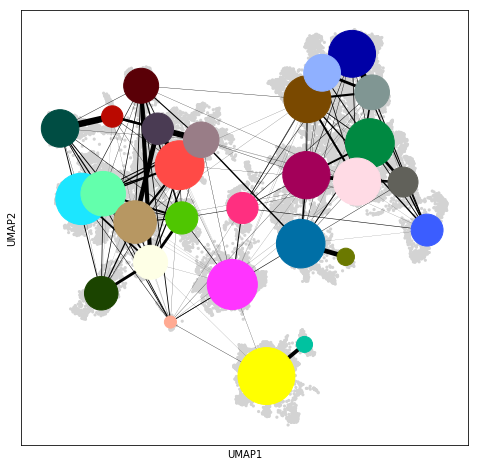

In [47]:
fig1, ax1 = plt.subplots()
sc.pl.umap(adata, size=40, ax=ax1, show=False)
sc.pl.paga(adata, pos=adata.uns['paga']['pos'], show=False, node_size_scale=10, node_size_power=1, ax=ax1, text_kwds={'alpha':0})
#plt.savefig('./figures/umap_paga_overlay_gut.pdf', dpi=300, format='pdf')
plt.show()

In [49]:
#Create new Anndata object with non-batch corrected data
adata_test = adata.copy()
adata_test.X = adata.raw.X

In [1]:
#Regress out counts and redo pre-processing
sc.pp.regress_out(adata_test, 'n_counts')
sc.pp.pca(adata_test, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata_test)

NameError: name 'sc' is not defined

In [ ]:
#Recalculate PAGA
sc.tl.paga(adata_test, groups='louvain_r0.5')
sc.pl.paga_compare(adata_test, basis='umap')
sc.pl.paga(adata_test)